<a href="https://colab.research.google.com/github/mariamudretchi/FE/blob/main/AutomatedFE_PracticePart_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload Kaggle dataset

In [ ]:
# Upload kaggle.json API token, and download / unzip NHL Game Data csv

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d martinellis/nhl-game-data
!unzip nhl-game-data.zip

 99% 239M/240M [00:02<00:00, 121MB/s]
100% 240M/240M [00:02<00:00, 109MB/s]
Archive:  nhl-game-data.zip
  inflating: game.csv                
  inflating: game_goalie_stats.csv   
  inflating: game_goals.csv          
  inflating: game_officials.csv      
  inflating: game_penalties.csv      
  inflating: game_plays.csv          
  inflating: game_plays_players.csv  
  inflating: game_scratches.csv      
  inflating: game_shifts.csv         
  inflating: game_skater_stats.csv   
  inflating: game_teams_stats.csv    
  inflating: player_info.csv         
  inflating: table_relationships.JPG  
  inflating: team_info.csv           


# Import librarii

In [ ]:
!pip install featuretools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.0/618.0 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 20.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import featuretools as ft
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Feature engineering pe NHL Game dataset

## Creare dataframes

In [ ]:
df_games = pd.read_csv("game.csv")

In [ ]:
df_games

,game_id,season,type,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz
0,2016020045,20162017,R,2016-10-19T00:30:00Z,4,16,4,7,home win REG,right,United Center,/api/v1/venues/null,America/Chicago,-5,CDT
1,2017020812,20172018,R,2018-02-07T00:00:00Z,24,7,4,3,away win OT,left,KeyBank Center,/api/v1/venues/null,America/New_York,-4,EDT
2,2015020314,20152016,R,2015-11-24T01:00:00Z,21,52,4,1,away win REG,right,MTS Centre,/api/v1/venues/null,America/Winnipeg,-5,CDT
3,2015020849,20152016,R,2016-02-17T00:00:00Z,52,12,1,2,home win REG,right,PNC Arena,/api/v1/venues/null,America/New_York,-4,EDT
4,2017020586,20172018,R,2017-12-30T03:00:00Z,20,24,1,2,home win REG,left,Honda Center,/api/v1/venues/null,America/Los_Angeles,-7,PDT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26300,2018030415,20182019,P,2019-06-07T00:00:00Z,19,6,2,1,away win REG,left,TD Garden,/api/v1/venues/5085,America/New_York,-5,EST
26301,2018030416,20182019,P,2019-06-10T00:00:00Z,6,19,5,1,away win REG,left,Enterprise Center,/api/v1/venues/5076,America/Chicago,-6,CST
26302,2018030416,20182019,P,2019-06-10T00:00:00Z,6,19,5,1,away win REG,left,Enterprise Center,/api/v1/venues/5076,America/Chicago,-6,CST
26303,2018030417,20182019,P,2019-06-13T00:00:00Z,19,6,4,1,away win REG,left,TD Garden,/api/v1/venues/5085,America/New_York,-5,EST


In [ ]:
df_plays = pd.read_csv("game_plays.csv")
df_plays

,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y
0,2016020045_1,2016020045,NaN,NaN,Game Scheduled,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-18 23:40:58,0,0,Game Scheduled,NaN,NaN
1,2016020045_2,2016020045,NaN,NaN,Period Ready,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-19 01:35:28,0,0,Period Ready,NaN,NaN
2,2016020045_3,2016020045,NaN,NaN,Period Start,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-19 01:40:50,0,0,Period Start,NaN,NaN
3,2016020045_4,2016020045,16.0,4.0,Faceoff,NaN,0.0,0.0,1,REGULAR,0,1200.0,2016-10-19 01:40:50,0,0,Jonathan Toews faceoff won against Claude Giroux,0.0,0.0
4,2016020045_5,2016020045,16.0,4.0,Shot,Wrist Shot,-71.0,9.0,1,REGULAR,54,1146.0,2016-10-19 01:41:44,0,0,Artem Anisimov Wrist Shot saved by Michal Neuv...,71.0,-9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5050524,2018030417_297,2018030417,6.0,19.0,Hit,NaN,48.0,38.0,3,REGULAR,1165,35.0,2019-06-13 03:40:33,4,1,Torey Krug hit Alexander Steen,48.0,38.0
5050525,2018030417_298,2018030417,6.0,19.0,Missed Shot,NaN,52.0,-27.0,3,REGULAR,1167,33.0,2019-06-13 03:40:30,4,1,Danton Heinen - Wide of Net,52.0,-27.0
5050526,2018030417_299,2018030417,NaN,NaN,Period End,NaN,NaN,NaN,3,REGULAR,1200,0.0,2019-06-13 03:41:10,4,1,End of 3rd Period,NaN,NaN
5050527,2018030417_300,2018030417,NaN,NaN,Period Official,NaN,NaN,NaN,3,REGULAR,1200,0.0,2019-06-13 03:46:18,4,1,Period Official,NaN,NaN


In [ ]:
df_plays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050529 entries, 0 to 5050528
Data columns (total 18 columns):
 #   Column               Dtype  
---  ------               -----  
 0   play_id              object 
 1   game_id              int64  
 2   team_id_for          float64
 3   team_id_against      float64
 4   event                object 
 5   secondaryType        object 
 6   x                    float64
 7   y                    float64
 8   period               int64  
 9   periodType           object 
 10  periodTime           int64  
 11  periodTimeRemaining  float64
 12  dateTime             object 
 13  goals_away           int64  
 14  goals_home           int64  
 15  description          object 
 16  st_x                 float64
 17  st_y                 float64
dtypes: float64(7), int64(5), object(6)
memory usage: 693.6+ MB


In [ ]:
df_plays.isnull().sum()

play_id                      0
game_id                      0
team_id_for             932705
team_id_against         932705
event                        0
secondaryType          3868513
x                      1134364
y                      1134333
period                       0
periodType                   0
periodTime                   0
periodTimeRemaining     193019
dateTime                     0
goals_away                   0
goals_home                   0
description                  0
st_x                   1134364
st_y                   1134364
dtype: int64

In [ ]:
# se elimina unele dintre campurile de tip string/object sau care sunt irelevante pentru model
df_plays = df_plays.drop(['secondaryType', 'dateTime', 'description', 'x', \
                          'y', 'st_x', 'st_y', 'team_id_for', 'team_id_against'], \
                         axis=1).reset_index(drop=True)

In [ ]:
df_plays.isnull().sum()

play_id                     0
game_id                     0
event                       0
period                      0
periodType                  0
periodTime                  0
periodTimeRemaining    193019
goals_away                  0
goals_home                  0
dtype: int64

In [ ]:
def fillna_columns(dataframe, columns):
  for column in columns:
    dataframe[column] = dataframe[column].fillna(dataframe[column].mean())
  return dataframe

df_plays = fillna_columns(df_plays, ['periodTimeRemaining'])

## Feature hashing pe coloanele "event" & "description"

In [ ]:
df_plays

,play_id,game_id,event,period,periodType,periodTime,periodTimeRemaining,goals_away,goals_home
0,2016020045_1,2016020045,Game Scheduled,1,REGULAR,0,1200.0,0,0
1,2016020045_2,2016020045,Period Ready,1,REGULAR,0,1200.0,0,0
2,2016020045_3,2016020045,Period Start,1,REGULAR,0,1200.0,0,0
3,2016020045_4,2016020045,Faceoff,1,REGULAR,0,1200.0,0,0
4,2016020045_5,2016020045,Shot,1,REGULAR,54,1146.0,0,0
...,...,...,...,...,...,...,...,...,...
5050524,2018030417_297,2018030417,Hit,3,REGULAR,1165,35.0,4,1
5050525,2018030417_298,2018030417,Missed Shot,3,REGULAR,1167,33.0,4,1
5050526,2018030417_299,2018030417,Period End,3,REGULAR,1200,0.0,4,1
5050527,2018030417_300,2018030417,Period Official,3,REGULAR,1200,0.0,4,1


In [ ]:
# se defineste Feature Hashing Vectorizer
vectorizer = HashingVectorizer(n_features=10, norm=None, alternate_sign=False, ngram_range=(1,1), binary=True)
vectorizer1 = HashingVectorizer(n_features=3, norm=None, alternate_sign=False, ngram_range=(1,1), binary=True)

# se aplica Hashing Vectorizer si se transforma coloanele "periodType" si "event"
X1 = vectorizer1.fit_transform(df_plays["periodType"])
X2 = vectorizer.fit_transform(df_plays["event"])

# se convertesc caracteristicile hashed in dataframes separate
hashed_periodType = pd.DataFrame(X1.toarray(), columns=[f"hashed_periodType_{i}" for i in range(3)])
hashed_event = pd.DataFrame(X2.toarray(), columns=[f"hashed_event_{i}" for i in range(10)])

# se concateneaza dataframe-ul cu caracteristicile codificate prin hashing cu dataframe-ul "df_plays"
df_plays = pd.concat([df_plays, hashed_periodType, hashed_event], axis=1)

df_plays

,play_id,game_id,event,period,periodType,periodTime,periodTimeRemaining,goals_away,goals_home,hashed_periodType_0,...,hashed_event_0,hashed_event_1,hashed_event_2,hashed_event_3,hashed_event_4,hashed_event_5,hashed_event_6,hashed_event_7,hashed_event_8,hashed_event_9
0,2016020045_1,2016020045,Game Scheduled,1,REGULAR,0,1200.0,0,0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016020045_2,2016020045,Period Ready,1,REGULAR,0,1200.0,0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2016020045_3,2016020045,Period Start,1,REGULAR,0,1200.0,0,0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2016020045_4,2016020045,Faceoff,1,REGULAR,0,1200.0,0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016020045_5,2016020045,Shot,1,REGULAR,54,1146.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5050524,2018030417_297,2018030417,Hit,3,REGULAR,1165,35.0,4,1,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5050525,2018030417_298,2018030417,Missed Shot,3,REGULAR,1167,33.0,4,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5050526,2018030417_299,2018030417,Period End,3,REGULAR,1200,0.0,4,1,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5050527,2018030417_300,2018030417,Period Official,3,REGULAR,1200,0.0,4,1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df_plays = df_plays.drop(['periodType', 'event'], axis=1)

In [ ]:
df_plays=df_plays.drop_duplicates(subset=["play_id"], keep=False).reset_index(drop=True)
df_plays

,play_id,game_id,period,periodTime,periodTimeRemaining,goals_away,goals_home,hashed_periodType_0,hashed_periodType_1,hashed_periodType_2,hashed_event_0,hashed_event_1,hashed_event_2,hashed_event_3,hashed_event_4,hashed_event_5,hashed_event_6,hashed_event_7,hashed_event_8,hashed_event_9
0,2016020045_1,2016020045,1,0,1200.0,0,0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016020045_2,2016020045,1,0,1200.0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2016020045_3,2016020045,1,0,1200.0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2016020045_4,2016020045,1,0,1200.0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016020045_5,2016020045,1,54,1146.0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3383592,2019030091_327,2019030091,3,1188,12.0,1,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3383593,2019030091_328,2019030091,3,1189,11.0,1,4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3383594,2019030091_329,2019030091,3,1198,2.0,1,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3383595,2019030091_330,2019030091,3,1200,0.0,1,4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
df_plays.isnull().sum()

play_id                0
game_id                0
period                 0
periodTime             0
periodTimeRemaining    0
goals_away             0
goals_home             0
hashed_periodType_0    0
hashed_periodType_1    0
hashed_periodType_2    0
hashed_event_0         0
hashed_event_1         0
hashed_event_2         0
hashed_event_3         0
hashed_event_4         0
hashed_event_5         0
hashed_event_6         0
hashed_event_7         0
hashed_event_8         0
hashed_event_9         0
dtype: int64

## Creare entity set

In [ ]:
# se defineste entity set-ul
es = ft.EntitySet(id="plays")
es = es.add_dataframe(
    dataframe_name="plays",
    dataframe=df_plays,
    index="play_id"
)

In [ ]:
es

Entityset: plays
  DataFrames:
    plays [Rows: 3383597, Columns: 20]
  Relationships:
    No relationships

In [ ]:
# se normalizeaza entitatile
es.normalize_dataframe(base_dataframe_name = 'plays', new_dataframe_name = 'games', index = 'game_id')

Entityset: plays
  DataFrames:
    plays [Rows: 3383597, Columns: 20]
    games [Rows: 20752, Columns: 1]
  Relationships:
    plays.game_id -> games.game_id

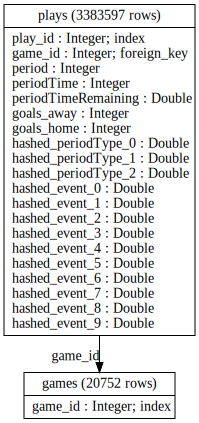

In [ ]:
es.plot()

## Aplicare Deep Feature Synthesis

In [ ]:
# se genereaza caracteristicile prin aplicarea Deep Feature Synthesis
feat, defs = ft.dfs(entityset=es, target_dataframe_name="games", max_depth = 2)

feat.reset_index(inplace=True)
feat.shape

(20752, 110)

In [ ]:
feat

,game_id,COUNT(plays),MAX(plays.goals_away),MAX(plays.goals_home),MAX(plays.hashed_event_0),MAX(plays.hashed_event_1),MAX(plays.hashed_event_2),MAX(plays.hashed_event_3),MAX(plays.hashed_event_4),MAX(plays.hashed_event_5),...,SUM(plays.hashed_event_6),SUM(plays.hashed_event_7),SUM(plays.hashed_event_8),SUM(plays.hashed_event_9),SUM(plays.hashed_periodType_0),SUM(plays.hashed_periodType_1),SUM(plays.hashed_periodType_2),SUM(plays.period),SUM(plays.periodTime),SUM(plays.periodTimeRemaining)
0,2016020045,299,4.0,7.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,53.0,93.0,28.0,0.0,299.0,0.0,577.0,176640.0,182160.0
1,2017020812,312,4.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,62.0,120.0,12.0,0.0,312.0,0.0,639.0,183675.0,183525.0
2,2017020240,301,1.0,4.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,52.0,118.0,24.0,0.0,301.0,0.0,586.0,180436.0,180764.0
3,2015020314,283,4.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,43.0,112.0,26.0,0.0,283.0,0.0,552.0,169371.0,170229.0
4,2017020624,307,0.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,60.0,122.0,8.0,0.0,307.0,0.0,591.0,185771.0,182629.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20747,2019030091,333,1.0,4.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,49.0,105.0,32.0,0.0,333.0,0.0,640.0,200009.0,199591.0
20748,2019030031,342,2.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,48.0,120.0,20.0,0.0,342.0,0.0,681.0,206054.0,204346.0
20749,2019030061,358,6.0,4.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,53.0,122.0,25.0,0.0,358.0,0.0,688.0,212057.0,217543.0
20750,2019030021,418,3.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,63.0,163.0,17.0,0.0,418.0,0.0,1001.0,228375.0,273225.0


In [ ]:
feat.columns

Index(['game_id', 'COUNT(plays)', 'MAX(plays.goals_away)',
       'MAX(plays.goals_home)', 'MAX(plays.hashed_event_0)',
       'MAX(plays.hashed_event_1)', 'MAX(plays.hashed_event_2)',
       'MAX(plays.hashed_event_3)', 'MAX(plays.hashed_event_4)',
       'MAX(plays.hashed_event_5)',
       ...
       'SUM(plays.hashed_event_6)', 'SUM(plays.hashed_event_7)',
       'SUM(plays.hashed_event_8)', 'SUM(plays.hashed_event_9)',
       'SUM(plays.hashed_periodType_0)', 'SUM(plays.hashed_periodType_1)',
       'SUM(plays.hashed_periodType_2)', 'SUM(plays.period)',
       'SUM(plays.periodTime)', 'SUM(plays.periodTimeRemaining)'],
      dtype='object', length=110)

In [ ]:
defs

[<Feature: COUNT(plays)>,
 <Feature: MAX(plays.goals_away)>,
 <Feature: MAX(plays.goals_home)>,
 <Feature: MAX(plays.hashed_event_0)>,
 <Feature: MAX(plays.hashed_event_1)>,
 <Feature: MAX(plays.hashed_event_2)>,
 <Feature: MAX(plays.hashed_event_3)>,
 <Feature: MAX(plays.hashed_event_4)>,
 <Feature: MAX(plays.hashed_event_5)>,
 <Feature: MAX(plays.hashed_event_6)>,
 <Feature: MAX(plays.hashed_event_7)>,
 <Feature: MAX(plays.hashed_event_8)>,
 <Feature: MAX(plays.hashed_event_9)>,
 <Feature: MAX(plays.hashed_periodType_0)>,
 <Feature: MAX(plays.hashed_periodType_1)>,
 <Feature: MAX(plays.hashed_periodType_2)>,
 <Feature: MAX(plays.period)>,
 <Feature: MAX(plays.periodTime)>,
 <Feature: MAX(plays.periodTimeRemaining)>,
 <Feature: MEAN(plays.goals_away)>,
 <Feature: MEAN(plays.goals_home)>,
 <Feature: MEAN(plays.hashed_event_0)>,
 <Feature: MEAN(plays.hashed_event_1)>,
 <Feature: MEAN(plays.hashed_event_2)>,
 <Feature: MEAN(plays.hashed_event_3)>,
 <Feature: MEAN(plays.hashed_event_4)>,


In [ ]:
feat = pd.merge(feat, df_games[['game_id', 'type']], on='game_id')

In [ ]:
# se realizeaza o clasificare binara unde meciurile obisnuite/"R" -> 1, iar cele play-off/"P" -> 0
feat['label'] = np.where(feat['type'] == 'R', 1, 0)

# se numara label-urile
label_counts = feat.groupby('label').size().reset_index(name='plays')

In [ ]:
label_counts

,label,plays
0,0,702
1,1,20050


In [ ]:
feat = feat.reset_index(drop=True)

In [ ]:
feat

,game_id,COUNT(plays),MAX(plays.goals_away),MAX(plays.goals_home),MAX(plays.hashed_event_0),MAX(plays.hashed_event_1),MAX(plays.hashed_event_2),MAX(plays.hashed_event_3),MAX(plays.hashed_event_4),MAX(plays.hashed_event_5),...,SUM(plays.hashed_event_8),SUM(plays.hashed_event_9),SUM(plays.hashed_periodType_0),SUM(plays.hashed_periodType_1),SUM(plays.hashed_periodType_2),SUM(plays.period),SUM(plays.periodTime),SUM(plays.periodTimeRemaining),type,label
0,2016020045,299,4.0,7.0,1.0,1.0,1.0,0.0,1.0,1.0,...,93.0,28.0,0.0,299.0,0.0,577.0,176640.0,182160.0,R,1
1,2017020812,312,4.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,...,120.0,12.0,0.0,312.0,0.0,639.0,183675.0,183525.0,R,1
2,2017020240,301,1.0,4.0,1.0,1.0,1.0,0.0,1.0,1.0,...,118.0,24.0,0.0,301.0,0.0,586.0,180436.0,180764.0,R,1
3,2015020314,283,4.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,112.0,26.0,0.0,283.0,0.0,552.0,169371.0,170229.0,R,1
4,2017020624,307,0.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,...,122.0,8.0,0.0,307.0,0.0,591.0,185771.0,182629.0,R,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20747,2019030091,333,1.0,4.0,1.0,1.0,1.0,0.0,1.0,1.0,...,105.0,32.0,0.0,333.0,0.0,640.0,200009.0,199591.0,P,0
20748,2019030031,342,2.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,...,120.0,20.0,0.0,342.0,0.0,681.0,206054.0,204346.0,P,0
20749,2019030061,358,6.0,4.0,1.0,1.0,1.0,0.0,1.0,1.0,...,122.0,25.0,0.0,358.0,0.0,688.0,212057.0,217543.0,P,0
20750,2019030021,418,3.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,...,163.0,17.0,0.0,418.0,0.0,1001.0,228375.0,273225.0,P,0


In [ ]:
# se definesc datele de intrare, X si variabila tinta, y
y = feat['label']
X= feat.drop(['label', 'game_id', 'type'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

In [ ]:
value_counts = pd.Series(y_train).value_counts(normalize=True)
value_counts

1    0.966155
0    0.033845
Name: label, dtype: float64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# se initializeaza undersampler-ul
undersampler = RandomUnderSampler(sampling_strategy=0.3, random_state=42)

# se aplica pe setul de date
X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [ ]:
value_counts_after = pd.Series(y_train).value_counts(normalize=True)
value_counts_after

1    0.769231
0    0.230769
Name: label, dtype: float64

In [ ]:
train_values = y_train.value_counts()
test_values = y_test.value_counts()
print("train values: \n", train_values, "\n\ntest values: \n", test_values)


train values: 
 1    1990
0     597
Name: label, dtype: int64 

test values: 
 1    3008
0     105
Name: label, dtype: int64


## Antrenare si predictie model

In [ ]:
from sklearn.metrics import confusion_matrix

def specificity_score(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

### Logistic regression

In [ ]:
# se antreneaza un model logistic de regresie
lr = LogisticRegression(max_iter=5000)
model = lr.fit(X_train, y_train)


y_pred = model.predict(X_test)
# se calculeaza acuratetea/precizia modelului in clasificarea datelor
model.score(X_test, y_test)

0.9383231609380019

In [ ]:
print("accuracy:", accuracy_score(y_test, y_pred))
print("precision:", precision_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))
print("f1:", f1_score(y_test, y_pred))

accuracy: 0.9383231609380019
precision: 0.9899095337508699
recall: 0.945811170212766
f1: 0.967358041482489


In [ ]:
# calculeaza scorul AUC-ROC pentru modelul logistic de regresie
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1] )

0.9476032168186423

In [ ]:
print(specificity_score(y_test, y_pred), "\n", confusion_matrix(y_test, y_pred))

0.7238095238095238 
 [[  76   29]
 [ 163 2845]]


### RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()
model = rf.fit(X_train, y_train)

y_pred = model.predict(X_test)
model.score(X_test, y_test)


0.9302923225184709

In [ ]:
print("accuracy:", accuracy_score(y_test, y_pred))
print("precision:", precision_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))
print("f1:", f1_score(y_test, y_pred))

accuracy: 0.9302923225184709
precision: 0.9887915936952715
recall: 0.9384973404255319
f1: 0.9629882312809143


In [ ]:
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.9369285081053698

In [ ]:
print(specificity_score(y_test, y_pred), "\n", confusion_matrix(y_test, y_pred))

0.6952380952380952 
 [[  73   32]
 [ 185 2823]]
